<a href="https://colab.research.google.com/github/fun-debug/demo/blob/main/d2l/attention-mechanisms/bahdanau-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5

In [2]:
!pip install matplotlib==3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.0.0-cp38-cp38-linux_x86_64.whl size=11844551 sha256=d7168a45ea33e08c61e000cd15246bb2af5c8293d4f69eb7d76d3b29267806c6
  Stored in directory: /root/.cache/pip/wheels/a9/1e/ed/3e09c67472517aa5d81f8c15de6c81162d249ebe442e4f3007
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 req

In [3]:
!nvidia-smi

Sun Feb 19 12:51:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self,**kwargs):
        super(AttentionDecoder,self).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError

In [6]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,
                 dropout=0,**kwargs):
        super(Seq2SeqAttentionDecoder,self).__init__(**kwargs)
        self.attention=d2l.AdditiveAttention(
            num_hiddens,num_hiddens,num_hiddens,dropout
        )
        self.embeding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(
            embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout
        )
        self.dense=nn.Linear(num_hiddens,vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens,*args):
        output,hidden_sate=enc_outputs
        return (output.permute(1,0,2),hidden_sate,enc_valid_lens)
    def forward(self, X, state):
        enc_outputs,hidden_sate,enc_valid_lens=state
        X=self.embeding(X).permute(1,0,2)
        outputs,self._attention_weights=[],[]
        for x in X:
            query=torch.unsqueeze(hidden_sate[-1],dim=1)
            context=self.attention(query,enc_outputs,enc_outputs,enc_valid_lens)
            x=torch.cat((context,torch.unsqueeze(x,dim=1)),dim=-1)
            out,hidden_sate=self.rnn(x.permute(1,0,2),hidden_sate)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs=self.dense(torch.cat(outputs,dim=0))
        return outputs.permute(1,0,2),[enc_outputs,hidden_sate,enc_valid_lens]
    @property
    def attention_weights(self):
        return self._attention_weights

In [7]:
encoder=d2l.Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
decoder=Seq2SeqAttentionDecoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
decoder.eval()
X=torch.zeros((4,7),dtype=torch.long)
state=decoder.init_state(encoder(X),None)
output,state=decoder(X,state)
output.shape,len(state),state[0].shape,len(state[1]),state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 7086.4 tokens/sec on cuda:0


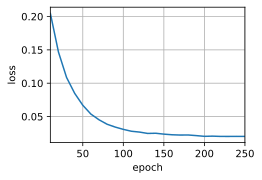

In [8]:
embed_size,num_hiddens,num_layers,dropout=32,32,2,0.1
batch_size,num_steps=64,10
lr,num_epochs,device=0.005,250,d2l.try_gpu()
train_iter,src_vocab,tgt_vocab=d2l.load_data_nmt(batch_size,num_steps)
encoder=d2l.Seq2SeqEncoder(len(src_vocab),embed_size,num_hiddens,num_layers,dropout)
decoder=Seq2SeqAttentionDecoder(
    len(tgt_vocab),embed_size,num_hiddens,num_layers,dropout
)
net=d2l.EncoderDecoder(encoder,decoder)
d2l.train_seq2seq(net,train_iter,lr,num_epochs,tgt_vocab,device)

In [9]:
engs=['go .','i lost .','he\'s calm .','i\'m home .']
fras=['va !','j\'ai perdu .','il est calme .', 'je suis chez moi .']
for eng,fra in zip(engs,fras):
    translation,dec_attention_weight_seq=d2l.predict_seq2seq(
        net,eng,src_vocab,tgt_vocab,num_steps,device,True
    )
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation,fra,k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [11]:
attention_weights=torch.cat([step[0][0][0] for step in dec_attention_weight_seq],0).reshape((
    1,1,-1,num_steps)
)

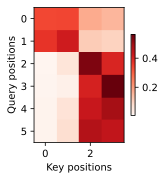

In [12]:
d2l.show_heatmaps(
    attention_weights[:,:,:,:len(engs[-1].split())+1].cpu(),
    xlabel='Key positions',ylabel='Query positions'
)